In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Se cargan los Features (X) generados en el notebook anterior
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/Networks_X_train.npy')
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/Networks_X_test.npy')

# Se cargan los Targets (y)
y_train_orig = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_train.npy')
y_test_orig = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_test.npy')

# Se carga el Tokenizer (necesario para saber el tamaño del vocabulario)
with open('/content/drive/MyDrive/Colab Notebooks/TFM/keras_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [2]:
# Se comprueban los tamaños de los datos cargados
print(f"Tamaño X_train: {X_train.shape}")
print(f"Tamaño X_test:  {X_test.shape}")
print(f"Tamaño y_train: {y_train_orig.shape}")
print(f"Tamaño y_train: {len(tokenizer.word_index) + 1}")

Tamaño X_train: (7842, 512)
Tamaño X_test:  (1961, 512)
Tamaño y_train: (7842,)
Tamaño y_train: 62095


In [3]:
# Se mapean las etiquetas (-1 -> 0, 0 -> 1, 1 -> 2)
y_train = to_categorical(y_train_orig + 1, num_classes=3)
y_test = to_categorical(y_test_orig + 1, num_classes=3)

# Se muestra un ejemplo para verificar
print(f"Etiqueta Original (ejemplo): {y_train_orig[0]}")
print(f"Etiqueta One-Hot (ejemplo):  {y_train[0]}")

Etiqueta Original (ejemplo): -1
Etiqueta One-Hot (ejemplo):  [1. 0. 0.]


In [4]:
# Se convierten las etiquetas de One-Hot a enteros simples para el cálculo
y_train_integers = np.argmax(y_train, axis=1)

# Se calculan los pesos para equilibrar
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

# Se crea el diccionario que necesita keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("Pesos de Clase Calculados:", class_weights_dict)
# Se muestra como se ha penalizado viendo que el valor de, que seria 1 es inferior a 1.

Pesos de Clase Calculados: {0: np.float64(5.280808080808081), 1: np.float64(3.2512437810945274), 2: np.float64(0.399510927709002)}


In [5]:
# Se definen los parámetros
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAX_LENGTH = X_train.shape[1]
EMBEDDING_DIM = 100

def build_lstm_model():
    model = Sequential([
        # Capa de Embedding
        Embedding(input_dim=VOCAB_SIZE,
                  output_dim=EMBEDDING_DIM,
                  input_length=MAX_LENGTH),

        # Capa LSTM Bidireccional
        # Bidirectional permite aprender del contexto pasado y futuro
        # return_sequences=False: Solo nos interesa la salida final de la secuencia
        Bidirectional(LSTM(64, return_sequences=False)),

        # Capas Densas para clasificación
        Dense(64, activation='relu'),
        Dropout(0.5), # Se apagan neuronas para regularizar

        # Capa de Salida
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Se construye y muestra el resumen del modelo
model = build_lstm_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Se configura el EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

BATCH_SIZE = 32
EPOCHS = 20

print("Iniciando Entrenamiento")
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=1
)


Iniciando Entrenamiento
Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.6402 - loss: 1.0727 - val_accuracy: 0.4331 - val_loss: 1.1038
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.6050 - loss: 1.0436 - val_accuracy: 0.6051 - val_loss: 0.9555
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7594 - loss: 0.8036 - val_accuracy: 0.5898 - val_loss: 1.0331
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.8180 - loss: 0.5290 - val_accuracy: 0.6764 - val_loss: 0.8233
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8858 - loss: 0.2730 - val_accuracy: 0.7389 - val_loss: 0.8260
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9468 - loss: 0.1372 - val_accuracy: 0.6561 - val_loss: 1.0896
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9470 - loss: 0.0994 - val_accuracy: 0.7758 - val_loss: 1.0232


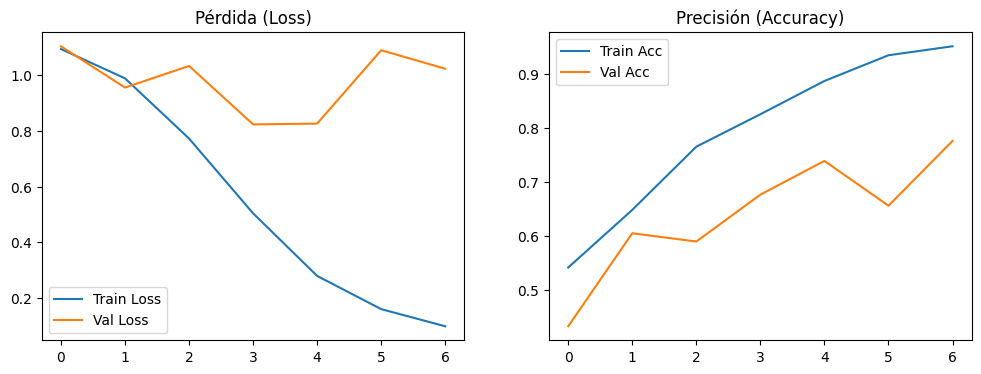

Evaluación en Test Set
Test Accuracy: 67.01%


In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Precisión (Accuracy)')
plt.legend()
plt.show()

# Se evalúa el modelo con el conjunto de test
print("Evaluación en Test Set")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
                      precision    recall  f1-score   support

Not Recommended (-1)       0.14      0.27      0.18       124
  Mixed Feelings (0)       0.17      0.30      0.22       201
     Recommended (1)       0.89      0.75      0.81      1636

            accuracy                           0.67      1961
           macro avg       0.40      0.44      0.40      1961
        weighted avg       0.77      0.67      0.71      1961



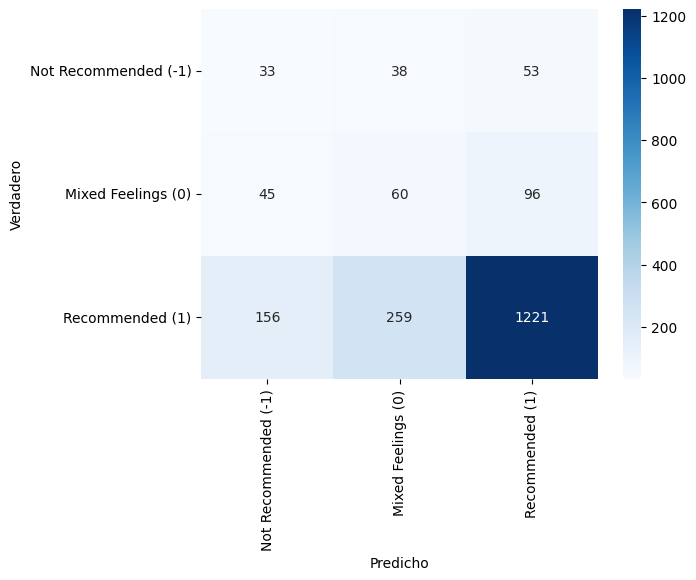

In [8]:
# Se predicen las clases
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Nombres de etiquetas originales
class_names = ['Not Recommended (-1)', 'Mixed Feelings (0)', 'Recommended (1)']

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Se muestra la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

In [9]:
# Se guarda el modelo
model.save('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_lstm_tfm.keras')
print("Modelo guardado")

Modelo guardado
